In [1]:
from transformers import RobertaTokenizer, RobertaModel
from datasets import load_dataset

/cis/home/adesilva/miniconda3/envs/myllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [3]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [11]:
dataset = load_dataset("nyu-mll/glue", "sst2")
def encode(example):
    return tokenizer(example['sentence'], padding='max_length', return_tensors='pt')
dataset.set_transform(encode)

In [14]:
dataset['test'][0]

{'input_ids': tensor([    0,  4438, 17400, 24601,   119,  1671,     9, 11019,     8, 23409,
           479,     2,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [2]:
f = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(10, 2),
)

In [3]:
a = torch.randn((1, 10))
f(a)

tensor([[-0.2505, -0.1224]], grad_fn=<AddmmBackward0>)

In [9]:
device = 'cuda:1'

In [4]:
dataset = load_dataset("nyu-mll/glue", "sst2")

In [5]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
tokenizer.encode_plus()

In [10]:
dataset = dataset.map(lambda e : tokenizer(e['sentence'], None, return_token_type_ids=True, max_length=256, pad_to_max_length=True), batched=True)

Map: 100%|██████████| 1821/1821 [00:00<00:00, 3071.87 examples/s]


In [17]:
len(dataset['train'][0]['token_type_ids'])

256

In [6]:
dataset = dataset.map(lambda e : tokenizer(e['sentence'], padding='max_length'), batched=True)

Map: 100%|██████████| 1821/1821 [00:00<00:00, 2458.72 examples/s]


In [7]:
dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
    num_rows: 872
})

In [8]:
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [9]:
trainloader = DataLoader(dataset['train'], batch_size=8, shuffle=True, num_workers=4)
testloader = DataLoader(dataset['validation'], batch_size=8, shuffle=True, num_workers=4)

In [33]:
class RoBERTaClassifier(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClassifier, self).__init__()
        self.encoder = RobertaModel.from_pretrained("roberta-base")
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 2)
        )

    def forward(self, input_ids, attention_mask):
        x = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        x = x[0][:, 0]
        x = self.classifier(x)
        return x

In [34]:
model = RoBERTaClassifier()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaClassifier(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [31]:
model.train()
for data in trainloader:
    ids = data['input_ids'].long().to(device)
    mask = data['attention_mask'].long().to(device)
    label = data['label'].int().to(device)
    print(len(label))
    # print(label)
    outputs = model(ids, mask)
    break

8


In [32]:
data['input_ids']

tensor([[    0,  1116,     5,  ...,     1,     1,     1],
        [    0, 25761,  9866,  ...,     1,     1,     1],
        [    0,   260, 29932,  ...,     1,     1,     1],
        ...,
        [    0,   879,   605,  ...,     1,     1,     1],
        [    0, 12465, 27566,  ...,     1,     1,     1],
        [    0,  2911, 24997,  ...,     1,     1,     1]])

In [18]:
import numpy as np

In [16]:
label

tensor([1, 1, 1, 1, 1, 1, 0, 0], device='cuda:1', dtype=torch.int32)

In [17]:
outputs

tensor([[ 0.0716, -0.0733],
        [ 0.0621, -0.0758],
        [ 0.0571, -0.1908],
        [ 0.0507, -0.0731],
        [ 0.0683, -0.0841],
        [ 0.0748, -0.1636],
        [ 0.0515, -0.0667],
        [ 0.0606, -0.0871]], device='cuda:1', grad_fn=<AddmmBackward0>)

In [30]:
(torch.argmax(outputs, axis=1) == label).detach().cpu().numpy().sum()

2

In [3]:
from lora.models import get_model
from omegaconf import OmegaConf

In [4]:
args = OmegaConf.load('../config.yaml')
args.freeze = True

In [6]:
model = get_model(args)
model.to(device)
model.train()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

In [67]:
for param in model.encoder.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [65]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [66]:
count_parameters(model)

592130

In [68]:
# model size
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2

In [7]:
from lora.models import get_model
from omegaconf import OmegaConf

In [8]:
args = OmegaConf.load('../config.yaml')
args.freeze = True

In [9]:
model = get_model(args)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import torch
from transformers import get_linear_schedule_with_warmup
from lora.utils import linear_schedule_with_warmup

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = get_linear_schedule_with_warmup(
#             optimizer,
#             num_warmup_steps=100,
#             num_training_steps=1500
#         )
scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=4120*60*0.06,
            num_training_steps=4120*60
        )

In [31]:
lr = []
for epoch in range(4120*60):
    scheduler.step(epoch)
    lr.append(scheduler.get_last_lr())

/cis/home/adesilva/miniconda3/envs/myllm/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/cis/home/adesilva/miniconda3/envs/myllm/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue i

In [32]:
import matplotlib.pyplot as plt

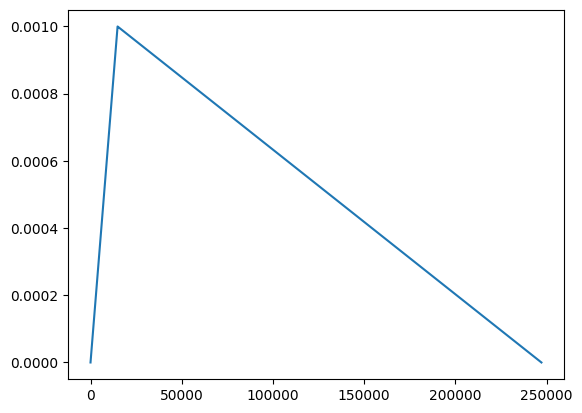

In [33]:
plt.plot(lr)

In [11]:
from lora.trainer import Trainer
from omegaconf import OmegaConf
import logging

In [8]:
args = OmegaConf.load('../config.yaml')
args.freeze = True
log = logging.getLogger(__name__)

In [12]:
trainer = Trainer(args, log)

TypeError: __init__() takes 2 positional arguments but 3 were given